In [1]:
from Simulation_PyAPDL import simulation_PyAPDL
from scipy.integrate import simps
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os


def get_MAC(mode_shape_model,mode_shape_exp):
    mode_shape_model = mode_shape_model.reshape(1, -1)
    mode_shape_exp = mode_shape_exp.reshape(1, -1)
    return np.power(np.dot(mode_shape_exp,np.transpose(mode_shape_model)),2)[0][0]/(np.dot(mode_shape_model,np.transpose(mode_shape_model))[0][0]*np.dot(mode_shape_exp,np.transpose(mode_shape_exp)))[0][0]

def fit_gaussian_kernel(f,f_n,zeta):
    # Compute the standard deviation (sigma) based on the damping ratio
    band_width_ratio = 1.1
    sigma = band_width_ratio*(zeta * f_n) / np.sqrt(2 * np.log(2))
    return np.exp(-0.5 * ((f - f_n) / sigma)**2)

def find_peaks_SDOFsup(num_peak,natrual_freq_arr,frf_freq_arr,targer_FRF,zeta, plot_ = False):
    frf_freq_arr = frf_freq_arr.reshape(1,-1)[0]
    targer_FRF = targer_FRF.reshape(1,-1)[0]
   
    peak_list = np.zeros(num_peak)
    peak_freq_list = np.zeros(num_peak)
    peak_energy_list = np.zeros(num_peak)
    kernel = np.zeros(len(frf_freq_arr))
    kernel_current_best = np.zeros(len(frf_freq_arr))
    
    for i_peak in range(num_peak):
        energy_remain_arr = np.ones(len(natrual_freq_arr))
 
        for i_freq_n in range(len(natrual_freq_arr)):#
            freq_target = natrual_freq_arr[i_freq_n]
            ampl = np.interp(freq_target, frf_freq_arr, targer_FRF)
            kernel = np.maximum(kernel_current_best, ampl*fit_gaussian_kernel(frf_freq_arr,freq_target,zeta))

            signal_remain = targer_FRF - kernel
            energy_remain_arr[i_freq_n] = simps(signal_remain**2, frf_freq_arr)

        peak_energy_list[i_peak] = np.min(energy_remain_arr)
        peak_pos = np.argmin(energy_remain_arr)
        peak_list[i_peak] =  peak_pos
        peak_freq_list[i_peak]  = natrual_freq_arr[peak_pos]
        
        freq_current_best = natrual_freq_arr[peak_pos]
        ampl_current_best= np.interp(freq_current_best, frf_freq_arr, targer_FRF)
        kernel_current_best = np.maximum(kernel_current_best, ampl_current_best*fit_gaussian_kernel(frf_freq_arr,freq_current_best,zeta))

    if plot_:
        plt.plot(frf_freq_arr, targer_FRF,linestyle=":")
        plt.plot(frf_freq_arr, kernel_current_best,linestyle=":")
        #plt.plot(frf_freq_arr, targer_FRF -kernel_current_best ,linestyle=":")
        plt.show()
    
    
    return np.sort(peak_list),np.sort(peak_freq_list)

def extract_mode_shape_vector(f_n_arr, frf_arr):
    ## Get mode shape from FRF
    i_model_1OG = np.array([ frf_arr['disp_ch9']['imag'].reshape(1,-1),
                            frf_arr['disp_ch10']['imag'].reshape(1,-1),
                            frf_arr['disp_ch11']['imag'].reshape(1,-1),
                            frf_arr['disp_ch12']['imag'].reshape(1,-1)])
    i_model_1OG_mat = np.vstack(i_model_1OG)
    max_i_1 = np.max(abs(i_model_1OG_mat))
    i_model_1OG_norm = i_model_1OG_mat/max_i_1

    i_model_2OG = np.array([ frf_arr['disp_ch3']['imag'].reshape(1,-1),
                            frf_arr['disp_ch13']['imag'].reshape(1,-1),
                            frf_arr['disp_ch14']['imag'].reshape(1,-1),
                            frf_arr['disp_ch15']['imag'].reshape(1,-1)])
    i_model_2OG_mat = np.vstack(i_model_2OG)
    max_i_2 = np.max(abs(i_model_2OG_mat))
    i_model_2OG_norm = i_model_2OG_mat/max_i_2

    f = frf_arr['disp_ch9']['freq'].reshape(1,-1)
    mode_shape_vector = np.zeros([len(f_n_arr),8])
    mode_freq_vector = np.zeros([len(f_n_arr)])

    i_mode = 0
    ampl_ratio = max_i_1/max_i_2
    for f_i_mode in f_n_arr:
        i_shape = 0
        mode_freq_vector[i_mode] = f_i_mode
        for i_mode_shape in range(4):
            mode_shape_1OG = np.interp(f_i_mode, f[0], i_model_1OG_norm[i_mode_shape,:])
            mode_shape_vector[i_mode,i_shape] = mode_shape_1OG
            i_shape = i_shape +1
            
        for i_mode_shape in range(4):
            mode_shape_2OG = np.interp(f_i_mode, f[0], i_model_2OG_norm[i_mode_shape,:]*ampl_ratio)
            mode_shape_vector[i_mode,i_shape] = mode_shape_2OG 
            i_shape = i_shape +1
        
        i_mode = i_mode +1

    return mode_freq_vector, mode_shape_vector

def mean_value_filted(data,std_dev_thres = 1):
    # Calculate the mean and standard deviation of the data
    mean = np.mean(data)
    std_dev = np.std(data)
    # Filter out outliers
    filtered_data = data[np.abs(data - mean) <= std_dev_thres * std_dev]
    # Calculate the mean of the remaining data
    return np.mean(filtered_data)

## MMI :Improved finite element model updating of a full-scale steel bridge using sensitivity analysis　(Bjørn T. Svendsen, 2021)

def get_MMI(f_n_model,f_n_exp, mac, f_n_ratio=0.5):
    return(1-f_n_ratio)*mac - f_n_ratio* abs(f_n_exp-f_n_model)/f_n_exp


## Obtain the exp data
# Case 13
i_file = 13
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")


1st natural freqeuncy: 12.1344, 2nd natural freqeuncy: 18.8672


In [2]:
simu_tk = simulation_PyAPDL(nproc=4,nerr=10000)
simu_tk.launch_engine()
simu_tk.mapdl.clear()

Launch Pymapdl
     Launch Pymapdl successfully, duration 3.0189 seconds.


- fix parameter: all of the nu
- vary parameter: t, e, rho, vs, dr, height
- Assumption: x_slab = t_stair
- Number of parameter reduced to: 19

In [ ]:
from pyDOE import lhs
import numpy as np
import json

# Generate LHS data
num_samples = 1000  # Number of samples
num_parameters = 19  # Number of parameters

# Create LHS data in [0, 1] range
X_samples = lhs(num_parameters, samples=num_samples)

# Convert to a Python list for JSON compatibility
X_samples_list = X_samples.tolist()


# Save to a JSON file
#with open('lhs_data.json', 'w') as json_file:
#    json.dump(X_samples_list, json_file, indent=4)  # indent for better readability
#print("LHS data saved to 'lhs_data.json'")



LHS data saved to 'lhs_data.json'


In [4]:
import os
from IPython.display import clear_output

DOE_info = {}
vary_ratio = 0.5
# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI/"

# Transform X from [0,1] to [-1,1]
X_transformed = 2 * X - 1

# 154 - 159 usgin 18 modeal
# 
for i_doe in range(29,1000):
    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)
    X_doe = X[i_doe,:]
    X_doe_transformed = X_transformed[i_doe,:]

    
    simu_tk.mapdl.clear()

    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                          0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                          0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                          0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                          0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                          0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    
    nu_para  = np.array([ 0.27,
                          0.27,
                          0.27,
                          0.27,
                          0.27,
                          0.27])
    
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                          2300 + vary_ratio*2300*X_transformed[i_doe,11],
                          2300 + vary_ratio*2300*X_transformed[i_doe,12],
                          2300 + vary_ratio*2300*X_transformed[i_doe,13],
                          2300 + vary_ratio*2300*X_transformed[i_doe,14],
                          2300 + vary_ratio*2300*X_transformed[i_doe,10]])

    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                           1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                           0.33 ])
    
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]

    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()


    # Excitation point: Hammer 2.0 Pos1 (shaker)
    tol = 0.3
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')

    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1.0, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    

    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)

 
    ## Get FRF at target point
    meas_FRFs = simu_tk.get_FRFs_meas_EXAMPLE()
  
    
    DOE_info = {
        'id':i_doe,
        'X':X_doe.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs
        }
    with open(full_path, "w") as file:
        json.dump(DOE_info, file, indent=4)  # `indent=4` for pretty printing
    simu_tk.mapdl.clear()
    clear_output(wait=True)
    

 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  4.986286766813828
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 6.3405 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1.0
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.05373076031225196
     Excitation node               :  3667
Using Modal-superpostion method


KeyboardInterrupt: Interrupted during MAPDL execution

In [55]:
import os
import json
import numpy as np
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

# Load the JSON file
i_doe = 1
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

for i_doe in range(0,1000):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,len(loaded_data['modal_info'])+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    mode_freq_1_list = np.zeros(8)
    mode_freq_2_list = np.zeros(8)
    mac_1_list = np.zeros(8)
    mac_2_list = np.zeros(8)
    #
    i_ch_disp = [9,10,11,12,3,13,14,15]
    for i_ch in range(8):
    #
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['ampl']),0.05)
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
    f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.4 or mac_2_mean <= 0.4:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

valid_X = X[i_doe_valid]
valid_Y0 = MMI_1[i_doe_valid]
valid_Y1 = MMI_2[i_doe_valid]
valid_Y2 = Fn_values_1[i_doe_valid]
valid_Y3 = Fn_values_2[i_doe_valid]
valid_Y4 = MAC_values_1[i_doe_valid]
valid_Y5 = MAC_values_2[i_doe_valid]

    
    #print(get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.5))
    #print(get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.5))
    #print(mac_2_list)
    #print(mode_freq_2_list)
    #for i_plot in i_ch_disp:
    #    plt.plot(loaded_data['meas_frf'][f'disp_ch{i_plot}']['freq'], loaded_data['meas_frf'][f'disp_ch{i_plot}']['imag'],linestyle=":")
    #plt.axvline(x=f_n_1_mean, color='red', linestyle='--', label=f'fn1:{f_n_1_mean}')
    #plt.axvline(x=f_n_2_mean, color='red', linestyle='--', label=f'fn2:{f_n_2_mean}')
    #plt.title(f'i_doe: {i_doe}')
    #plt.legend()
    #plt.show()


### Using Random Forest Classifier extract the featrue importance

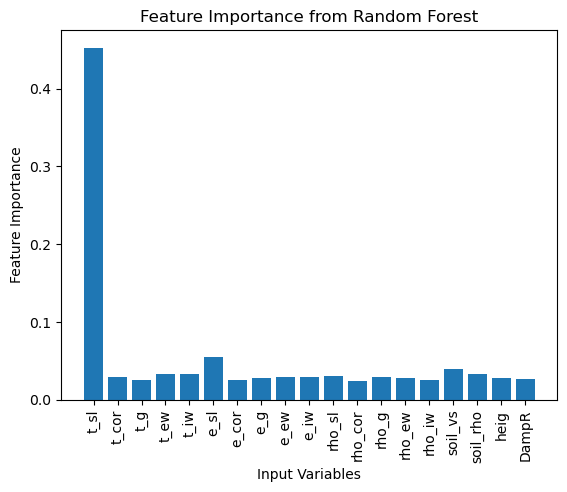

              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83        95
         1.0       0.91      0.94      0.93       205

    accuracy                           0.90       300
   macro avg       0.89      0.87      0.88       300
weighted avg       0.90      0.90      0.90       300



In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)
y = np.ones(1000)
y[i_doe_wrong] = 0

input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']

# Create a DataFrame for easier handling
data = pd.DataFrame(X, columns=input_name)
data['fn_1'] = Fn_values_1
data['fn_2'] = Fn_values_2
data['MAC_1'] = MAC_values_1
data['MAC_2'] = MAC_values_2
data['non'] = MAC_values_2


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get feature importance
feature_importance = clf.feature_importances_

# Print or visualize feature importance

plt.bar(range(len(feature_importance)), feature_importance,tick_label = input_name)
plt.xlabel("Input Variables")
plt.ylabel("Feature Importance")
plt.title("Feature Importance from Random Forest")
plt.xticks(rotation=90)
plt.show()

# Evaluate the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))







### Find the correlation using pearson and spearman method

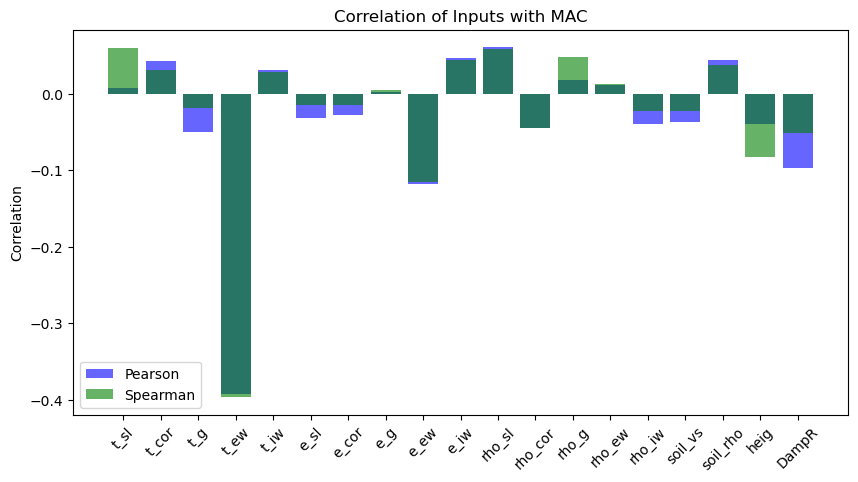

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


data_type = 'MAC_1'


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)
input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']

# Create a DataFrame for easier handling
data = pd.DataFrame(X, columns=input_name)
data['fn_1'] = Fn_values_1
data['fn_2'] = Fn_values_2
data['MAC_1'] = MAC_values_1
data['MAC_2'] = MAC_values_2
data['non'] = MAC_values_2

data = data[data['MAC_1'] >= 0.4]
data = data[data['MAC_2'] >= 0.4]


# Compute Pearson correlation
pearson_corr = data.corr(method='pearson')[data_type][:-1]  # Exclude 'MAC' with itself

# Compute Spearman correlation
spearman_corr = data.corr(method='spearman')[data_type][:-1]  # Exclude 'MAC' with itself

sorted_pearson = pearson_corr.abs().sort_values(ascending=False)
sorted_spearman = spearman_corr.abs().sort_values(ascending=False)

#print("Top Inputs by Pearson Correlation:")
#print(sorted_pearson.head())

#print("Top Inputs by Spearman Correlation:")
#print(sorted_spearman.head())


# Plot correlations
plt.figure(figsize=(10, 5))
plt.bar(range(len(pearson_corr))[:19], pearson_corr[:19], label='Pearson', alpha=0.6, color='blue')
plt.bar(range(len(spearman_corr))[:19], spearman_corr[:19], label='Spearman', alpha=0.6, color='green')

plt.xticks(range(len(pearson_corr))[:19], pearson_corr.index[:19], rotation=45)
plt.ylabel('Correlation')
plt.title('Correlation of Inputs with MAC')
plt.legend()
plt.show()


### Visualization of correlation
- Only focus on the data that MAC 1 and MAC 2 larger than 0.4

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

data_type = 'fn_1'
num_inputs = 24
num_cols = 5  # Number of plots per row
num_rows = (num_inputs + num_cols - 1) // num_cols  # Calculate rows dynamically

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows), constrained_layout=True)
axes = axes.flatten()

for i, input_col in enumerate(data.columns[:-1]):  # Exclude 'MAC'
    # Compute Pearson correlation
    result= linregress(data[input_col], data[data_type])
    corr = result.rvalue

    # Plot with regression line
    sns.regplot(
        x=input_col, y=data_type, data=data,
        ax=axes[i], line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5}
    )
    axes[i].set_title(f"{data_type} vs {input_col}\nPearson r: {corr:.2f}")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()


### Building the surrogate model using GPR with PCA for dimension reduction

In [59]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

inputs = valid_X
outputs = valid_Y5

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.1, random_state=42)

# Initialize PCA
pca = PCA(n_components=10)  # Choose the number of components (e.g., 10)

# Fit PCA on training inputs and transform both training and test sets
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PCA components: {explained_variance}")



Explained variance by PCA components: [0.07417467 0.06840661 0.06665707 0.06417816 0.06250462 0.0592578
 0.05764941 0.05651632 0.05515344 0.05186099]


R² Score: -0.3473963096013648
NMSE: 1.3473963096013646


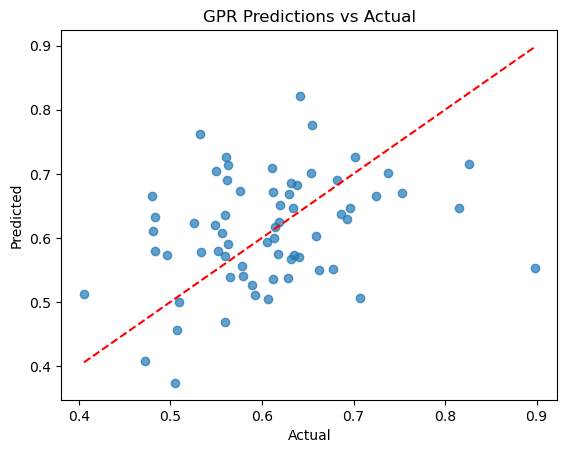

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train, y_train)

# Predict on the test set
y_pred = gpr.predict(X_test)

# Compute R² score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

# Compute NMSE (Normalized Mean Squared Error)
nmse = mean_squared_error(y_test, y_pred) / np.var(y_test)
print(f"NMSE: {nmse}")


plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual")
plt.show()


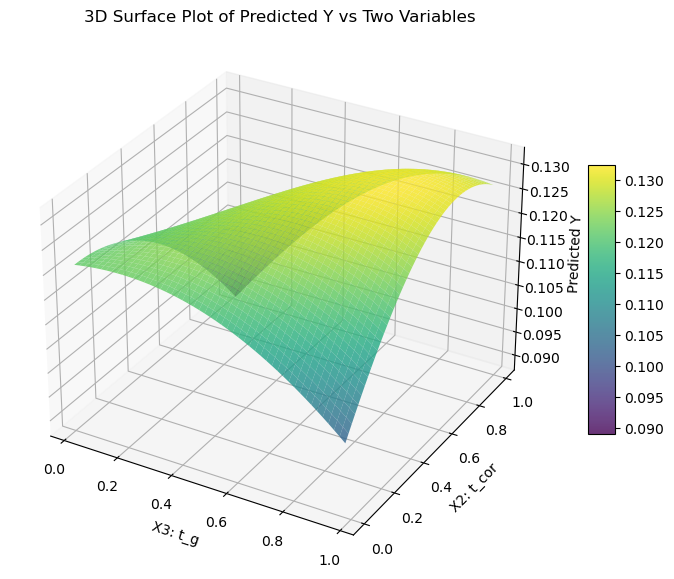

In [54]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the indices of the two variables you want to vary
var1_index = 2  # Index for the 5th variable (Python is zero-indexed)
var2_index = 1  # Index for the 10th variable

input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']

# Select the desired variables from X_test
var1 = X_test[:, var1_index]
var2 = X_test[:, var2_index]

# Calculate the mean of the remaining 17 variables
mean_vars = np.mean(X_test, axis=0)


# Generate a grid of values for var1 and var2 (these will vary, others are fixed)
var1_grid, var2_grid = np.meshgrid(np.linspace(var1.min(), var1.max(), 50),
                                   np.linspace(var2.min(), var2.max(), 50))

# Flatten the grids for var1 and var2 to create 1D arrays
var1_flat = var1_grid.ravel()
var2_flat = var2_grid.ravel()

# Create a new input matrix for predictions
# Stack the selected variables and tile the other variables' mean values
X_grid = np.column_stack([  np.tile(mean_vars, (len(var1_flat), 1))])
X_grid[:,var1_index] = var1_flat
X_grid[:,var2_index] = var2_flat
# Generate predictions for the grid (assuming gpr is your trained model)
y_pred_grid = gpr.predict(X_grid).reshape(var1_grid.shape)

# Now, y_pred_grid has shape (50, 50), matching the grid's shape

# Create a 3D figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot

surf = ax.plot_surface(var1_grid, var2_grid, y_pred_grid, cmap='viridis', alpha=0.8)
#ax.scatter(var1, var2, y_test, c='red', label='Test Results', s=50)

# Add labels and title
ax.set_xlabel(f'X{var1_index + 1}: {input_name[var1_index]}')
ax.set_ylabel(f'X{var2_index + 1}: {input_name[var2_index]}')
ax.set_zlabel('Predicted Y')

ax.set_title('3D Surface Plot of Predicted Y vs Two Variables')
# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# Show the plot
plt.show()


